# A simple model ARMA model with Kalman filter

A collection of simple examples to familiarise myself with statsmodels, will include a simple kalman filter

In [1]:
import numpy as np
print("numpy")
import pandas as pd
print("pandas")
import matplotlib.pyplot as plt
print("matplotlib")

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
print("SARIMAX")
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
print("ACFs")

numpy
pandas
matplotlib
SARIMAX
ACFs


## Simple AR model with white noise

The simplist time series model is the standard AR model with few coeffcients. This class requires that the initial state and k lagged states are explicitly set so that k+1th state can be generated. Additive gaussian noise was introduced to create uncertainty in the time series states. The const value is seperate but should be inluded in the vector product. 

In [2]:
class simpleTimeSeries:
    """ Simple ARMA model with b = 1 and White noise independant of t:
            Y_t+k+1 = const + a*Y_t+k + ... + a*Y_t + W
    """
    
    def generateSeries(self,coeffs,const, initial_state, n, noise_var,seed):
    #Creator function to generate points can be removed from class
    
        
        # Initialise
        data_series = np.zeros(n);
        rng = np.random.default_rng(seed)
        #rng = np.random.RandomState(seed)
        white_noise = rng.normal(0, noise_var, n) 
        k = initial_state.shape[0];
        
        # Set initial states
        for i,ini_val in enumerate(initial_state):
            data_series[i] = ini_val
        
        # Generate proceeding time series states
        for i in range(k,n):
            data_series[i] = np.dot(coeffs, data_series[i-k:i]) + white_noise[i-1] +const
            
        return data_series
    
    def __init__(self, coeffs, const, initial_state, n, noise_var, seed):
        """ Generate time series for model
        
            coeffs:         coeffcients of AR model (largest delay first) #Should reverse for standard convention
            const:          AR model constant term
            initial_state:  Given k initial states corresponding to k lags in model
            n:              Number of points to generate (includes initial_states)
            noise_var:      Variance of added white noise (set to 0 to exlude)
            seed:           RNG seed
        """
        self.time_series = self.generateSeries(coeffs,const,initial_state,n,noise_var,seed)
    
    def printSeries(self):
        """ Prints time series
        """
        
        for iter in self.time_series:
            print(iter)
            
    #Create graphing functions that section data in series


An AR(1) model was created but the complexity of an AR(2) was more interesting as a stable AR(1) is just an exponential decay. White noise with a variance of 0.05 was used to represent possible higher order features of the model or error in state measurement.

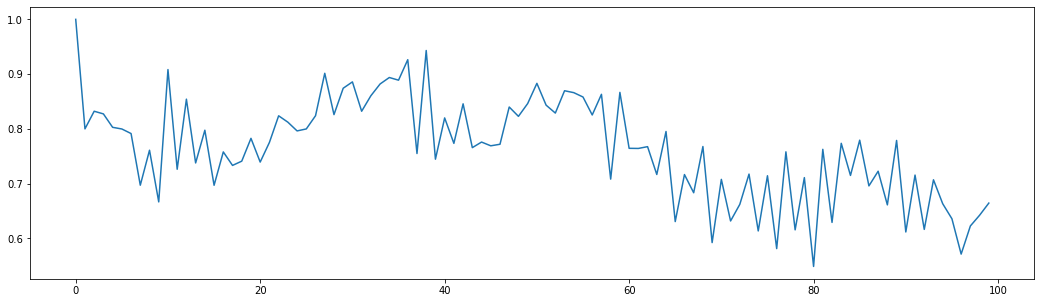

In [21]:
seed = 3
n=100 # number of samples
initial_values = np.array([1,.8])
ar_coeffs = np.array([.8,.2])
ar_const = 0
noise_var = 0.05#0.05

double_exp = simpleTimeSeries(ar_coeffs,ar_const,initial_values,n,noise_var,seed) #Y_t = .2*Y_(t-1) + .8*Y_(t-2) + W
data_series = double_exp.time_series

plt.figure(figsize=(18,5))
plt.plot(range(n),double_exp.time_series)


endog = pd.DataFrame(data_series,index=range(n)) #Wasted memeory incoporate in class or just use function

# AR(1)
#simple_exp = simpleTimeSeries(np.array([.9]),0,np.array([1]),n,0) #Y_t = .9*Y_(t-1)
#plt.plot(range(n),simple_exp.time_series)

A couple random seeds were tried to get a time series with clear trend. Now since the model is linear with gaussian noise, we know no difference is required so d = 0 in our ARIMA model. To confirm this we plot the ACF function 

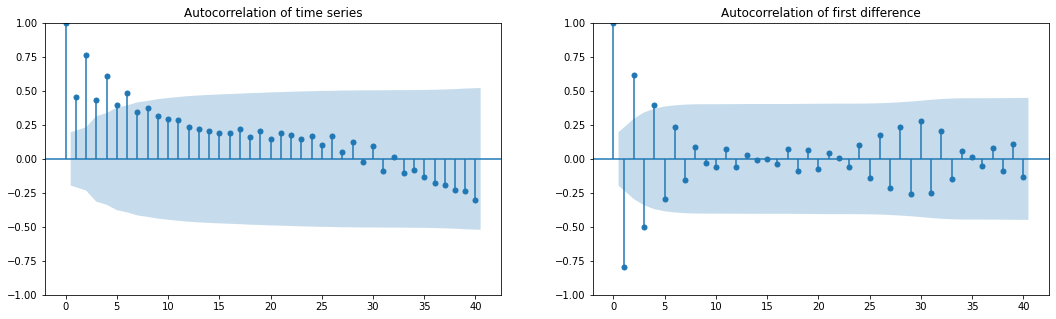

In [4]:
#plot_acf(endog, lags=50)
fig, ax = plt.subplots(1,2,figsize=(18,5))
sm.graphics.tsa.plot_acf(endog, lags=40, ax=ax[0], title ="Autocorrelation of time series")
sm.graphics.tsa.plot_acf(endog.diff().dropna(), lags=40, ax=ax[1],title ="Autocorrelation of first difference")
plt.show()

As expected the autocorrelation of first difference value for the first lag has a large negative value. This indicates that the sum was overdifferenced as it cannot have serve oppositely covariance with previous value and be a decaying exponential. Next we look at the PACF and ACF graphs to determine p and q respectively. 

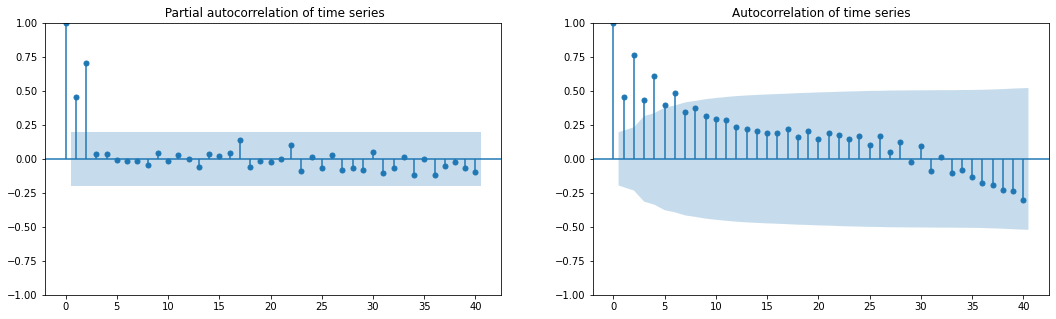

In [5]:
fig, ax = plt.subplots(1,2,figsize=(18,5))
sm.graphics.tsa.plot_pacf(endog, lags=40, method="ywm", ax=ax[0],title =" Partial autocorrelation of time series")
sm.graphics.tsa.plot_acf(endog, lags=40, ax=ax[1], title ="Autocorrelation of time series")
plt.show()

It comes as no suprise that the PACF plot shows two significant values for the first two terms, so it will obviously be an AR(2). Similarly the ACF plot has 6 significant values due to the large amount of noise injected into each state in the equations, however we shall start off ignoring it.

## AR(2) Forecasting

A simple statsmodels ARMA model is fitted to the first 80% of our data with the remaining 20% used as test data for its forecasting.

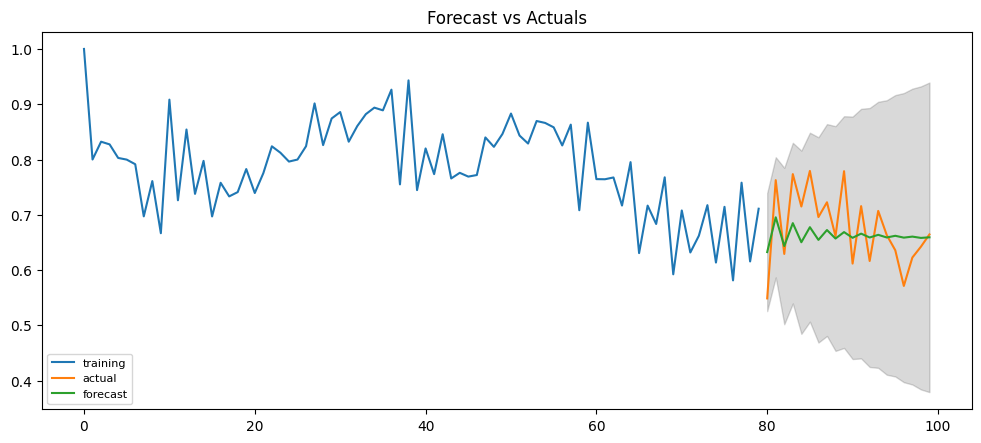

                               SARIMAX Results                                
Dep. Variable:                      0   No. Observations:                   80
Model:               SARIMAX(2, 0, 0)   Log Likelihood                 115.958
Date:                Tue, 12 Apr 2022   AIC                           -225.917
Time:                        11:34:11   BIC                           -218.771
Sample:                             0   HQIC                          -223.052
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1862      0.059      3.163      0.002       0.071       0.302
ar.L2          0.8125      0.059     13.738      0.000       0.697       0.928
sigma2         0.0030      0.000      7.078      0.0

In [45]:
# Training/Testing data split
nobs = len(endog)
n_training = int(nobs * 0.8)
train = endog.iloc[:n_training]
test = endog.iloc[n_training:]
n_test = len(test)+1

# Create simple AR(2) model
my_ar2 = sm.tsa.SARIMAX(train, order=(2,0, 0)).fit()
#my_ar2 = ar2.fit()

# Forecast
forecast = my_ar2.get_forecast(n_test, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(forecast.predicted_mean, index=test.index)
conf = forecast.conf_int(alpha=0.05)
lower_series = pd.Series(conf.iloc[:,0], index=test.index)
upper_series = pd.Series(conf.iloc[:,1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)

plt.title('Forecast vs Actuals')
plt.legend(loc='lower left', fontsize=8)
plt.show()

print(my_ar2.summary())

Looking at the summary, it is clear both coeffcients ar.L1 and ar.L2 are significant with P>|z| being less than our significance level of 0.05. The graph reveals that our model quickly converges to a mean as uncertainty increase with each further forecast. This behaviour is expected for our model as it represents a 2 lag process without noise. Since we essentially used white noise to represent non-linear features of the model generating the signal the generated AR(2) cannot capture this behaviour as seen below.

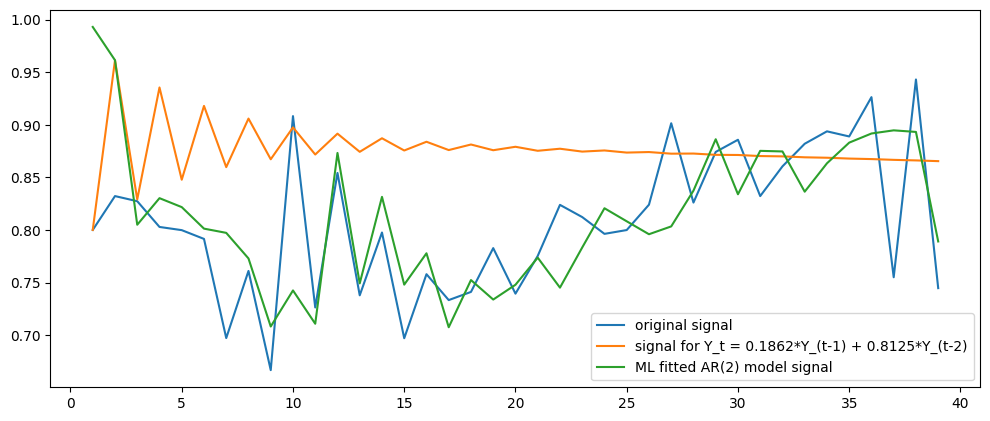

In [36]:
# Use interpolated point-prediction for the model
res_plot = my_ar2.predict(1,39)

# Generate a time series for the AR(2) for our ML selected model parameters
double_res = simpleTimeSeries(np.array([0.8125,0.1862]),0,np.array([1,0.8]),n,0,seed)

# Plotting
plt.figure(figsize=(12,5), dpi=100)

plt.plot(range(1,40),double_exp.time_series[1:40],label='original signal')
plt.plot(range(1,40),double_res.time_series[1:40],label='signal for Y_t = 0.1862*Y_(t-1) + 0.8125*Y_(t-2)')
plt.plot(range(1,40),res_plot,label='ML fitted AR(2) model signal')

plt.legend()

[0.63258837 0.67987561 0.5878949  0.73681469 0.65527658 0.76171395
 0.7260439  0.76281797 0.69997904 0.71029009 0.6822839  0.74675806
 0.6302961  0.69624652 0.63252563 0.69798345 0.65736548 0.62300911
 0.58016707 0.62555731]


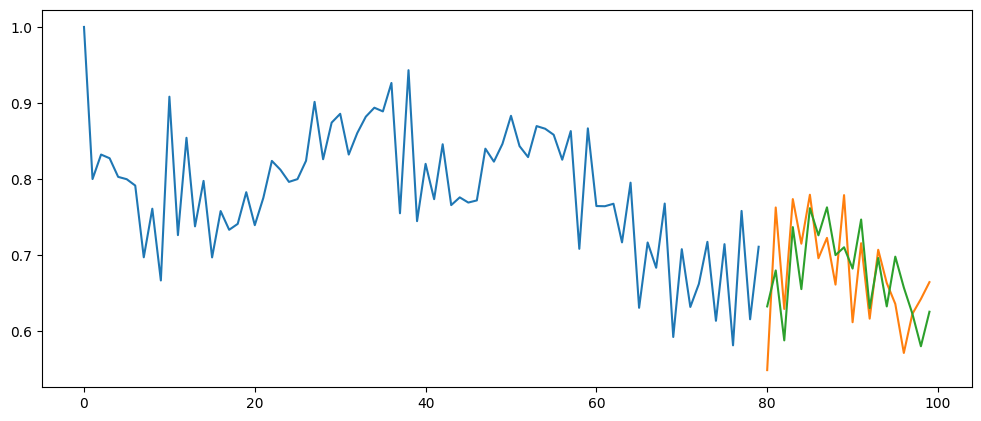

In [60]:
# Setup forecasts
nforecasts = 1 #3
forecasts = {}
#train_endog = endog
my_ar2_f = sm.tsa.SARIMAX(train, order=(2,0, 0)).fit()


# Save initial forecast
forecasts[train.index[-1]] = my_ar2_f.forecast(steps=nforecasts)

# Step through the rest of the sample
for t in range(n_training, nobs):
    # Update the results by appending the next observation
    updated = endog.iloc[t:t+1]
    my_ar2_f = my_ar2_f.extend(updated)

    # Save the new set of forecasts
    forecasts[updated.index[0]] = my_ar2_f.forecast(steps=nforecasts)

# Combine all forecasts into a dataframe
forecasts = pd.concat(forecasts, axis=1)


#print(forecasts.iloc[15,15])
temp = np.zeros(20)
for t in range(0,20):
    temp[t] = forecasts.iloc[t,t]
    
print(temp)
## Forecast
#forecast = my_ar2.get_forecast(n_test, alpha=0.05)  # 95% conf

# Make as pandas series
#fc_series = pd.Series(forecast.predicted_mean, index=test.index)
#conf = forecast.conf_int(alpha=0.05)
#lower_series = pd.Series(conf.iloc[:,0], index=test.index)
#upper_series = pd.Series(conf.iloc[:,1], index=test.index)

## Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(range(n_training, nobs),temp, label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)

#plt.title('Forecast vs Actuals')
#plt.legend(loc='lower left', fontsize=8)
#plt.show()


(array([ 3.,  5.,  2.,  3.,  6.,  4.,  6.,  8., 11.,  9., 14.,  8.,  7.,
         4.,  3.,  1.,  1.,  2.,  1.,  1.]),
 array([-0.2       , -0.17791859, -0.15583718, -0.13375577, -0.11167436,
        -0.08959295, -0.06751154, -0.04543013, -0.02334872, -0.00126731,
         0.0208141 ,  0.04289551,  0.06497692,  0.08705833,  0.10913974,
         0.13122115,  0.15330256,  0.17538397,  0.19746538,  0.21954679,
         0.2416282 ]),
 <BarContainer object of 20 artists>)

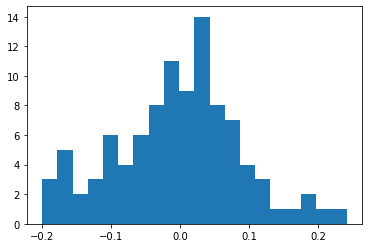

In [44]:
plt.hist(endog.diff(), bins=20)

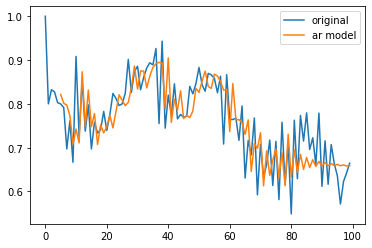

In [37]:
plt.plot(range(n),double_exp.time_series,label='original')
#plt.plot(range(n),double_res.time_series,label='reconstructed')
#double_nonoise = simpleTimeSeries(np.array([.8,.2]),0,np.array([1,0.4]),n,0)
#plt.plot(range(n),double_nonoise.time_series,label='original no noise')
##plt.plot(range(2,10),res_plot,label='ar model')
res_plot = my_ar2.predict(5,n-1)
plt.plot(range(5,n),res_plot,label='ar model')

plt.legend()

In [ ]:
#print(double_nonoise.time_series[99])
#endog = pd.DataFrame(data_series,index=range(n))
# Setup forecasts
#nforecasts = 3
#forecasts = {}

## Get the number of initial training observations
#nobs = len(endog)
#n_init_training = int(nobs * 0.8)

## Create model for initial training sample, fit parameters
#training_endog = endog.iloc[:n_init_training]
#mod = sm.tsa.SARIMAX(training_endog, order=(1, 0, 0), trend='n')
#res = mod.fit()

## Save initial forecast
#forecasts[training_endog.index[-1]] = res.forecast(steps=nforecasts)

# Step through the rest of the sample
#for t in range(n_init_training, nobs):
#    # Update the results by appending the next observation
#    updated_endog = endog.iloc[t:t+1]
#    res = res.extend(updated_endog)

#    # Save the new set of forecasts
#    forecasts[updated_endog.index[0]] = res.forecast(steps=nforecasts)

## Combine all forecasts into a dataframe
#forecasts = pd.concat(forecasts, axis=1)

#print(forecasts.iloc[:5, :5])
#print(double_res.time_series[99])

##res = AutoReg(simple_exp.time_series,1).fit()
##res = AutoReg(double_exp.time_series[0:50],2).fit()
##print(res.summary())